# NYC Restaurants

## Initial set-up

### import the libraries and dataset

In [12]:
# libraries
%matplotlib notebook
%matplotlib inline
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime as dt

In [13]:
# import 6 dataset text files with headers
data1 = pd.read_csv('DOHMH_New_York_City_Restaurant_Inspection_Results_1_of_6.txt', sep = ',', header = 0)
data2 = pd.read_csv('DOHMH_New_York_City_Restaurant_Inspection_Results_2_of_6.txt', sep = ',', header = 0)
data3 = pd.read_csv('DOHMH_New_York_City_Restaurant_Inspection_Results_3_of_6.txt', sep = ',', header = 0)
data4 = pd.read_csv('DOHMH_New_York_City_Restaurant_Inspection_Results_4_of_6.txt', sep = ',', header = 0)
data5 = pd.read_csv('DOHMH_New_York_City_Restaurant_Inspection_Results_5_of_6.txt', sep = ',', header = 0)
data6 = pd.read_csv('DOHMH_New_York_City_Restaurant_Inspection_Results_6_of_6.txt', sep = ',', header = 0)

# combine into one dataframe
nyc = pd.concat([data1, data2, data3, data4, data5, data6], axis=0)

### data cleaning

In [14]:
# See first 10 entries
nyc.head()

# Basic summary
print("Number of rows: ", str(nyc.shape[0]))
print("Number of columns: ", str(nyc.shape[1]))
print("Column names: ", str(nyc.columns))
print("Index method: ", str(nyc.index))
print("Data types for entire dataframe: ")
nyc.info()


Number of rows:  399918
Number of columns:  19
Column names:  Index(['Unnamed: 0', 'CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE',
       'PHONE', 'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION',
       'VIOLATION CODE', 'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE',
       'GRADE', 'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE'],
      dtype='object')
Index method:  Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            66643, 66644, 66645, 66646, 66647, 66648, 66649, 66650, 66651,
            66652],
           dtype='int64', length=399918)
Data types for entire dataframe: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 399918 entries, 0 to 66652
Data columns (total 19 columns):
Unnamed: 0               399918 non-null int64
CAMIS                    399918 non-null int64
DBA                      399559 non-null object
BORO                     399918 non-null object
BUILDING                 399809 no

In [15]:
# rename first column
nyc = nyc.rename(columns={ nyc.columns[0]: "uniqueID" })

# eliminate any easy duplicates
nyc = nyc.drop_duplicates()

# convert to datetime
nyc['INSPECTION DATE'] = pd.to_datetime(nyc['INSPECTION DATE'])
# nyc['GRADE DATE'] = pd.to_datetime(nyc['GRADE DATE'])
# nyc['RECORD DATE'] = pd.to_datetime(nyc['RECORD DATE'])

## EDA

### How many inspections per year are being done at restaurants?

In [16]:
nyc['inspection_year'] = nyc['INSPECTION DATE'].map(lambda x: x.strftime('%Y'))
nyc.groupby('inspection_year').size()


inspection_year
1900      1135
2011         2
2012         9
2013      5710
2014     80984
2015    116946
2016    116053
2017     79079
dtype: int64

In [17]:
# number of restaurants and the number of times they've been inspected
rests = nyc.groupby('CAMIS')
rests = rests.count()
rests = rests.sort_values('uniqueID', ascending = False)
rests = rests.rename(index=str, columns={"uniqueID": "total_inspections"})
rests.drop(['DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE',
       'PHONE', 'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION',
       'VIOLATION CODE', 'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE',
       'GRADE', 'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE', 'inspection_year'], axis=1, inplace=True)
rests.reset_index(inplace = True)
rests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26505 entries, 0 to 26504
Data columns (total 2 columns):
CAMIS                26505 non-null object
total_inspections    26505 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.2+ KB


In [19]:
# adding this as a column to dataframe for future use
rests['CAMIS']=pd.to_numeric(rests['CAMIS'])
nyc = pd.merge(nyc, rests, on='CAMIS', how='right')

In [20]:
# Why are some restaurants having so many inspections every year?!
rest_by_year = nyc.groupby(['CAMIS', 'inspection_year', 'total_inspections'])
rest_by_year = rest_by_year.count()
rest_by_year = rest_by_year.sort_values(['total_inspections', 'CAMIS', 'inspection_year'], ascending = False)

In [22]:
rest_by_year

uniqueID  DBA  BORO  BUILDING  \
CAMIS    inspection_year total_inspections                                  
41683816 2017            97                       12   12    12        12   
         2016            97                       35   35    35        35   
         2015            97                       39   39    39        39   
         2014            97                       11   11    11        11   
50001880 2016            95                       38   38    38        38   
         2015            95                       22   22    22        22   
         2014            95                       35   35    35        35   
40965177 2017            94                       13   13    13        13   
         2016            94                       30   30    30        30   
         2015            94                       33   33    33        33   
         2014            94                       18   18    18        18   
50033122 2017            91                       11   11    11        11   
         2016            91                       23   23    23        23   
         2015            91                       57   57    57        57   
41510846 2017            90                       25   25    25        25   
         2016            90                       14   14    14        14   
         2015            90                       29   29    29        29   
         2014            90                       22   22    22        22   
41459659 2017            90                        2    2     2         2   
         2016            90                       22   22    22        22   
         2015            90                       42   42    42        42   
         2014            90                       24   24    24        24   
41289382 2017            88                       24   24    24        24   
         2016            88                       29   29    29        29   
         2015            88                       27   27    27        27   
         2014            88                        8    8     8         8   
41630632 2017            86                       18   18    18        18   
         2016            86                       32   32    32        32   
         2015            86                       20   20    20        20   
         2014            86                       16   16    16        16   
...                                              ...  ...   ...       ...   
50047151 2017            1                         1    1     1         1   
50046909 1900            1                         1    1     1         1   
50046795 2016            1                         1    1     1         1   
50046793 2016            1                         1    1     1         1   
50046760 2016            1                         1    1     1         1   
50046749 1900            1                         1    1     1         1   
50046626 2016            1                         1    1     1         1   
50046624 2017            1                         1    1     1         1   
50046500 1900            1                         1    1     1         1   
50046194 2017            1                         1    1     1         1   
50046083 2016            1                         1    1     1         1   
50046056 1900            1                         1    1     1         1   
50045963 1900            1                         1    0     1         1   
50045891 2016            1                         1    1     1         1   
50045802 2016            1                         1    1     1         1   
50045766 1900            1                         1    0     1         1   
50045367 2016            1                         1    1     1         1   
50044891 2017            1                         1    1     1         1   
50044654 2017            1                         1    1     1         1   
50044339 1900            1              

### What kind of inspections are being done?

In [23]:
inspections = nyc.groupby('INSPECTION TYPE')
inspections = inspections.count()
inspections = inspections.sort_values('uniqueID', ascending = False)
print("Number of inspection types: ", str(inspections.shape[0]))
print("Total number of unique inspections: ", str(nyc.shape[0]))
inspections

Number of inspection types:  34
Total number of unique inspections:  399918


,uniqueID,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,inspection_year,total_inspections
INSPECTION TYPE,,,,,,,,,,,,,,,,,,,,
Cycle Inspection / Initial Inspection,230431,230431,230431,230431,230366,230431,230431,230431,230431,230431,230431,229870,229696,230431,230431,75876,75717,230431,230431,230431
Cycle Inspection / Re-inspection,99436,99436,99436,99436,99423,99436,99436,99436,99436,99436,99436,99198,99091,99436,99436,97384,97377,99436,99436,99436
Pre-permit (Operational) / Initial Inspection,24702,24702,24702,24702,24687,24702,24702,24702,24702,24702,24702,24550,24515,24702,24702,8909,7269,24702,24702,24702
Pre-permit (Operational) / Re-inspection,10568,10568,10568,10568,10568,10568,10568,10568,10568,10568,10568,10505,10485,10568,10568,10232,10200,10568,10568,10568
Administrative Miscellaneous / Initial Inspection,7911,7911,7911,7911,7910,7911,7911,7911,7911,7911,7911,6062,6062,7911,0,3,2,7911,7911,7911
Smoke-Free Air Act / Initial Inspection,4107,4107,4107,4107,4106,4107,4107,4107,4107,4107,4107,3975,3847,4107,2,0,0,4107,4107,4107
Pre-permit (Non-operational) / Initial Inspection,3957,3957,3957,3957,3956,3957,3957,3957,3957,3957,3957,3691,3691,3957,3957,689,2,3957,3957,3957
Cycle Inspection / Reopening Inspection,3221,3221,3221,3221,3221,3221,3221,3221,3221,3221,3221,3070,3070,3221,3220,1839,1839,3221,3221,3221
Trans Fat / Initial Inspection,2910,2910,2910,2910,2909,2910,2910,2910,2910,2910,2910,2464,2464,2910,0,0,0,2910,2910,2910


There are 34 categories of inspections, but the initial inspections alone make up 57.62% of the total number, and the re-inspections make up an additional 24.86% so I will focus initially just on those, rather than the more specialized inspection types that are based on permits, calorie postings, smoking, trans-fats, etc since I'm most interested in preventing critical food-borne illnesses. This will also help control for some variation due to nuances of different inspect protocols that I'm not aware of.

In [24]:
# filtered down to just these two types of inspections
init_ins = nyc[nyc['INSPECTION TYPE'] == "Cycle Inspection / Initial Inspection"]
re_ins = nyc[nyc['INSPECTION TYPE'] == "Cycle Inspection / Re-inspection"]

In [25]:
# combine with above to filter out the unusual inspection types
rest_by_year = re_ins.groupby(['CAMIS', 'inspection_year', 'total_inspections'])
rest_by_year = rest_by_year.count()
rest_by_year = rest_by_year.sort_values(['total_inspections', 'CAMIS', 'inspection_year'], ascending = False)
rest_by_year

uniqueID  DBA  BORO  BUILDING  \
CAMIS    inspection_year total_inspections                                  
41683816 2017            97                        6    6     6         6   
         2016            97                       14   14    14        14   
         2015            97                       14   14    14        14   
         2014            97                        5    5     5         5   
50001880 2016            95                       18   18    18        18   
         2015            95                       11   11    11        11   
         2014            95                       12   12    12        12   
40965177 2017            94                        3    3     3         3   
         2016            94                        8    8     8         8   
         2015            94                       16   16    16        16   
         2014            94                        5    5     5         5   
50033122 2017            91                        5    5     5         5   
         2016            91                       11   11    11        11   
         2015            91                       11   11    11        11   
41510846 2017            90                       13   13    13        13   
         2016            90                        4    4     4         4   
         2015            90                       14   14    14        14   
         2014            90                        4    4     4         4   
41459659 2017            90                        2    2     2         2   
         2016            90                        2    2     2         2   
         2015            90                       13   13    13        13   
         2014            90                       11   11    11        11   
41289382 2017            88                        3    3     3         3   
         2016            88                       10   10    10        10   
         2015            88                       11   11    11        11   
         2014            88                        4    4     4         4   
41630632 2017            86                       13   13    13        13   
         2016            86                       10   10    10        10   
         2015            86                        8    8     8         8   
         2014            86                        6    6     6         6   
...                                              ...  ...   ...       ...   
50033415 2017            5                         1    1     1         1   
50032946 2017            5                         2    2     2         2   
50012091 2017            5                         1    1     1         1   
50011955 2015            5                         2    2     2         2   
50007613 2015            5                         1    1     1         1   
50001587 2017            5                         2    2     2         2   
41688500 2016            5                         1    1     1         1   
41688139 2015            5                         1    1     1         1   
41688135 2014            5                         1    1     1         1   
41396863 2017            5                         1    1     1         1   
41396662 2016            5                         1    1     1         1   
41396659 2015            5                         1    1     1         1   
40959649 2015            5                         1    1     1         1   
40799206 2014            5                         2    2     2         2   
40719863 2017            5                         1    1     1         1   
40708598 2015            5                         1    1     1         1   
40368018 2015            5                         1    1     1         1   
50057826 2017            4                         1    1     1         1   
50054544 2017            4                         1    1     1         1   
50053704 2017            4              

In [26]:
rest_by_year['uniqueID'].describe()

count    31289.000000
mean         3.177986
std          1.876047
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         21.000000
Name: uniqueID, dtype: float64

restaurants generally get 1-4 reinspections per year, but one has as many as 21?!?

Found an external document that summarizes how NYC health department scores and grades restaurants [here](https://www1.nyc.gov/assets/doh/downloads/pdf/rii/how-we-score-grade.pdf). 


Key points:
- supposed to monitor ~24k restaurants per year
- Restaurants with a score between 0 and 13 points earn an A, those with 14 to 27 points receive a B and those with 28 or more a C
- not graded usually means failed to get an A
- Inspectors assign additional points to reflect the extent of the violation. A violation’s condition level can range from 1 (least extensive) to 5 (most extensive). For example, the presence of one contaminated food item is a condition level 1 violation, generating 7 points. Four or more contaminated food items is a condition level 4 violation, resulting in 10 points. 

Major violation types:
- PUBLIC HEALTH HAZARD, such as failing to keep food at the right temperature, triggers a minimum of 7 points. If the violation can’t be corrected before the inspection ends, the Health Department may close the restaurant until it’s fixed. 
- CRITICAL VIOLATION, for example, serving raw food such as a salad without properly washing it first, carries a minimum of 5 points.
- GENERAL VIOLATION, such as not properly sanitizing cooking utensils, receives at least 2 points. 

In [17]:
crit_re = re_ins.groupby(['GRADE','CRITICAL FLAG'])
crit_re = crit_re.count()
crit_re = crit_re.sort_values('uniqueID', ascending = False)
crit_re

uniqueID  CAMIS    DBA   BORO  BUILDING  \
GRADE          CRITICAL FLAG                                             
A              Critical           33360  33360  33360  33360     33355   
               Not Critical       30771  30771  30771  30771     30765   
B              Critical           17362  17362  17362  17362     17360   
               Not Critical        8137   8137   8137   8137      8137   
C              Critical            4055   4055   4055   4055      4055   
               Not Critical        1723   1723   1723   1723      1723   
Z              Critical            1077   1077   1077   1077      1077   
               Not Critical         552    552    552    552       552   
A              Not Applicable       316    316    316    316       316   
B              Not Applicable        16     16     16     16        16   
C              Not Applicable         5      5      5      5         5   
Not Yet Graded Not Critical           5      5      5      5         5   
Z              Not Applicable         3      3      3      3         3   
Not Yet Graded Critical               2      2      2      2         2   

                               STREET  ZIPCODE  PHONE  CUISINE DESCRIPTION  \
GRADE          CRITICAL FLAG                                                 
A              Critical         33360    33360  33360                33360   
               Not Critical     30771    30771  30771                30771   
B              Critical         17362    17362  17362                17362   
               Not Critical      8137     8137   8137                 8137   
C              Critical          4055     4055   4055                 4055   
               Not Critical      1723     1723   1723                 1723   
Z              Critical          1077     1077   1077                 1077   
               Not Critical       552      552    552                  552   
A              Not Applicable     316      316    316                  316   
B              Not Applicable      16       16     16                   16   
C              Not Applicable       5        5      5                    5   
Not Yet Graded Not Critical         5        5      5                    5   
Z              Not Applicable       3        3      3                    3   
Not Yet Graded Critical             2        2      2                    2   

                               INSPECTION DATE  ACTION  VIOLATION CODE  \
GRADE          CRITICAL FLAG                                             
A              Critical                  33360   33360           33360   
               Not Critical              30771   30771           30771   
B              Critical                  17362   17362           17362   
               Not Critical               8137    8137            8137   
C              Critical                   4055    4055            4055   
               Not Critical               1723    1723            1723   
Z              Critical                   1077    1077            1077   
               Not Critical                552     552             552   
A              Not Applicable              316     316              78   
B              Not Applicable               16      16              16   
C              Not Applicable                5       5               5   
Not Yet Graded Not Critical                  5       5               5   
Z              Not Applicable                3       3               3   
Not Yet Graded Critical                      2       2               2   

                               VIOLATION DESCRIPTION  SCORE  GRADE DATE  \
GRADE          CRITICAL FLAG                                              
A              Critical                        33360  33360       33360   
               Not Critical                    30771  30771       30771   
B              Critical                        17362  17362       17362   
               Not Critical          

Strangely, the number of restaurants with 'A' grades with critical flags are similar to the number of restaurants without critical flags! However, the proportion of restaurants without critical flags do have more 'A' grades. But there are restaurants without critical flags still receiving 'C' grades. W

In [28]:
# focus on violoation score instead?
re_ins['SCORE'].describe()

count    99436.000000
mean        15.493594
std         10.277420
min         -1.000000
25%         10.000000
50%         12.000000
75%         19.000000
max        115.000000
Name: SCORE, dtype: float64

In [30]:
re_ins.head()

,uniqueID,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,...,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE,inspection_year,total_inspections
2,6788,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,2016-12-15,...,06D,"Food contact surface not properly washed, rins...",Critical,15.0,B,12/15/2016,08/28/2017,Cycle Inspection / Re-inspection,2016,38
3,30948,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,2016-01-16,...,04L,Evidence of mice or live mice present in facil...,Critical,12.0,A,01/16/2016,08/28/2017,Cycle Inspection / Re-inspection,2016,38
4,33201,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,2015-07-10,...,10B,Plumbing not properly installed or maintained;...,Not Critical,32.0,C,07/10/2015,08/28/2017,Cycle Inspection / Re-inspection,2015,38
6,66723,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,2015-02-10,...,06C,Food not protected from potential source of co...,Critical,26.0,B,02/10/2015,08/28/2017,Cycle Inspection / Re-inspection,2015,38
7,81127,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,2016-12-15,...,04N,Filth flies or food/refuse/sewage-associated (...,Critical,15.0,B,12/15/2016,08/28/2017,Cycle Inspection / Re-inspection,2016,38


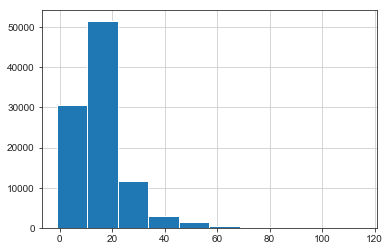

In [29]:
hist = re_ins['SCORE'].hist(bins = 10)

Okay I'll filter down even more to be only those restaurants that have scores of less than 40.

# HERE IS WHERE I HIT THE 4 HOUR MARK. GEEZ NOT ENOUGH. I NEED TO MOVE ALONG AND WILL TRY TO DO MORE TOMORROW. THE ACTUAL IMPORTANT PART OF THE ANALYSES.

## Deeper looks

In [ ]:
# as above but specifically by year and for reinspections only
ins_per_year = nyc.groupby(['CAMIS', 'inspection_year', 'INSPECTION TYPE'])
ins_per_year = ins_per_year.count()
ins_per_year = ins_per_year.sort_values('PHONE', ascending = False)
ins_per_year.drop(['DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE',
       'uniqueID', 'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION',
       'VIOLATION CODE', 'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE',
       'GRADE', 'GRADE DATE', 'RECORD DATE'], axis=1, inplace=True)
ins_per_year.reset_index(inplace = True)
ins_per_year.info()

Inspection years labeled 1900 have not yet been inspected, so those should not be included in any serious analysis.

Why do some restaurants get reinspected so many times within a single year? Is there any assocaition between number of inspections per year with violation score?

GOAL: compare number of times a restaurant is inspected per year versus what the violation score is.

In [197]:
re_ins.head()

,uniqueID,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,...,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE,inspection_year,total_inspections
2,6788,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,2016-12-15,...,06D,"Food contact surface not properly washed, rins...",Critical,15.0,B,2016-12-15,2017-08-28,Cycle Inspection / Re-inspection,2016,38
3,30948,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,2016-01-16,...,04L,Evidence of mice or live mice present in facil...,Critical,12.0,A,2016-01-16,2017-08-28,Cycle Inspection / Re-inspection,2016,38
4,33201,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,2015-07-10,...,10B,Plumbing not properly installed or maintained;...,Not Critical,32.0,C,2015-07-10,2017-08-28,Cycle Inspection / Re-inspection,2015,38
6,66723,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,2015-02-10,...,06C,Food not protected from potential source of co...,Critical,26.0,B,2015-02-10,2017-08-28,Cycle Inspection / Re-inspection,2015,38
7,81127,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,2016-12-15,...,04N,Filth flies or food/refuse/sewage-associated (...,Critical,15.0,B,2016-12-15,2017-08-28,Cycle Inspection / Re-inspection,2016,38


In [49]:
re_ins2 = re_ins.groupby(['CAMIS','inspection_year'])
re_ins2 = re_ins2.count()
re_ins2 = re_ins2.sort_values(['CAMIS', 'inspection_year'], ascending = False)
re_ins2.drop(['DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE',
        'PHONE', 'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION',
        'VIOLATION CODE', 'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE',
        'GRADE', 'GRADE DATE', 'RECORD DATE', 'uniqueID', 'total_inspections'], axis=1, inplace=True)
re_ins2.reset_index(inplace = True)
re_ins2

,CAMIS,inspection_year,INSPECTION TYPE
0,50064308,2017,2
1,50060557,2017,2
2,50060308,2017,2
3,50060017,2017,2
4,50059954,2017,2
5,50059792,2017,2
6,50059712,2017,2
7,50059091,2017,3
8,50058911,2017,1
9,50058772,2017,3


surprising that many of the rows near the top don't have multiple years. did those just get shut down right away?

In [52]:
# adding this as a column to dataframe for future use
re_ins = pd.merge(re_ins, re_ins2, on=['CAMIS', 'inspection_year'], how='right')
re_ins

,uniqueID,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,...,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE_x,inspection_year,total_inspections,INSPECTION TYPE_y
0,6788,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,2016-12-15,...,"Food contact surface not properly washed, rins...",Critical,15.0,B,12/15/2016,08/28/2017,Cycle Inspection / Re-inspection,2016,38,7
1,30948,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,2016-01-16,...,Evidence of mice or live mice present in facil...,Critical,12.0,A,01/16/2016,08/28/2017,Cycle Inspection / Re-inspection,2016,38,7
2,81127,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,2016-12-15,...,Filth flies or food/refuse/sewage-associated (...,Critical,15.0,B,12/15/2016,08/28/2017,Cycle Inspection / Re-inspection,2016,38,7
3,101562,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,2016-12-15,...,Evidence of mice or live mice present in facil...,Critical,15.0,B,12/15/2016,08/28/2017,Cycle Inspection / Re-inspection,2016,38,7
4,185957,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,2016-01-16,...,Plumbing not properly installed or maintained;...,Not Critical,12.0,A,01/16/2016,08/28/2017,Cycle Inspection / Re-inspection,2016,38,7
5,209856,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,2016-12-15,...,Facility not vermin proof. Harborage or condit...,Not Critical,15.0,B,12/15/2016,08/28/2017,Cycle Inspection / Re-inspection,2016,38,7
6,227783,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,2016-01-16,...,Facility not vermin proof. Harborage or condit...,Not Critical,12.0,A,01/16/2016,08/28/2017,Cycle Inspection / Re-inspection,2016,38,7
7,33201,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,2015-07-10,...,Plumbing not properly installed or maintained;...,Not Critical,32.0,C,07/10/2015,08/28/2017,Cycle Inspection / Re-inspection,2015,38,9
8,66723,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,2015-02-10,...,Food not protected from potential source of co...,Critical,26.0,B,02/10/2015,08/28/2017,Cycle Inspection / Re-inspection,2015,38,9
9,113947,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,2015-07-10,...,Hot food item not held at or above 140Âº F.,Critical,32.0,C,07/10/2015,08/28/2017,Cycle Inspection / Re-inspection,2015,38,9


In [61]:
# final cleaned up dataset that I'm going to work with
re_ins = re_ins[re_ins['SCORE'] <= 40]

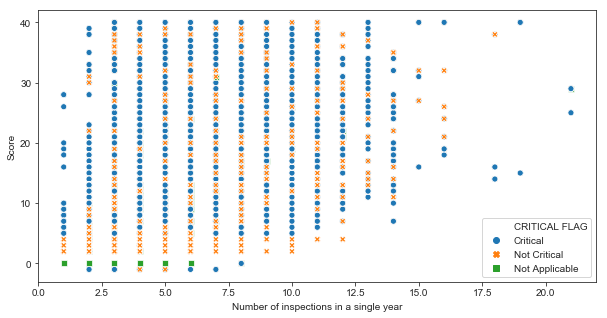

In [63]:
plt.figure(figsize=(10,5))
sns.set_style("ticks")
rest_plot = sns.scatterplot(x="INSPECTION TYPE_y", y="SCORE", hue = "CRITICAL FLAG", style="CRITICAL FLAG", data=re_ins)
plt.xlabel('Number of inspections in a single year')
plt.ylabel('Score')
rest_plot

Critical flags in general do not seem to be that great a of cue--they're found at a range of scores and number of inspections per year. Rather it seems that those places receiving over 10 reinspections in a single year have lower than 'A' scores, but still are planty of reinspections happening. Maybe best place to focus is in thos places with high scores that are receiving very few reinspections per year.

### Because of limited resources for inspections, is there a way to prioritize inspections?

Based on a linear mixed model, see which features most correlate with a higher violation score.

In [185]:
re_ins.columns

Index(['uniqueID', 'CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE',
       'PHONE', 'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION',
       'VIOLATION CODE', 'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE',
       'GRADE', 'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE',
       'inspection_year', 'total_inspections'],
      dtype='object')

# SUMMARY OF TAKEAWAYS HERE

### Model check

In [189]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

feature_names = ['CAMIS', 'BORO', 'CUISINE DESCRIPTION', 'inspection_year',
                 'total_inspections'
                      ]
X = re_ins[feature_names]
y = re_ins['SCORE']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

linridge = Ridge(alpha=20.0).fit(X_train, y_train)

ValueError: could not convert string to float: 'MANHATTAN'